In [1]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

# Reading Data in

In [2]:
df_train=pd.read_csv("enron_train.txt",sep="\t",header=None)
df_test=pd.read_csv("enron_test.txt",sep="\t",header=None)

In [3]:
df_train.columns=["pred","content"]
df_test.columns=["pred","content"]

In [4]:
df_train.head()

,pred,content
0,No,>>> [1]Contact Me Now to Make $100 Today!$LINK
1,No,Act now to keep your life on the go!
2,No,Choose between $500 and $10000 dollars with up...
3,No,Click above to earn today.
4,No,Click here to receive your first $10 today:


In [5]:
df_test.tail()

,pred,content
987,Yes,Could you call me on Monday with further infor...
988,Yes,Please call me at your convenience to discuss.
989,Yes,Please call the list around 200 to see if peop...
990,Yes,Please give us a call tomorrow to discuss brie...
991,Yes,Please review the below and lets discuss if th...


## Step 1 : Data Preprocessing, Expanding contractions & performing data cleaning operations on the text data

In [6]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

## Cleaning Text - removing stopwords, excess spaces, punctuations, special characters, removing httml tags & email IDs.

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,?#]')
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = text.lstrip()   
    text = text.rstrip()
    text = expandContractions(text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = re.sub('[^a-zA-Z ]'," ",text)
    text = re.sub("'ll"," ",text)
    text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"," ",text)
    text = re.sub(r"\$\d+", " ",text)
    text = re.sub(r'[\w\.-]+@[\w\.-]+', " ",text)
    text = re.sub(r'\b(me|her|him|us|them|there|that)\b', " ",text)  
    return text

In [8]:
df_train['content'] = df_train['content'].astype(str).apply(clean_text)
df_test['content'] = df_test['content'].astype(str).apply(clean_text)

# Step 2 : Transforming the text with TF-IDF and related techniques for modelling


### Lemmatizing the text, lemmatization drills down the words into their root form for better processing

In [9]:
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    return [lemmatizer.lemmatize(word) for word in word_tokenize(text) if len(word)>2 and (word not in STOPWORDS)]

In [10]:
STOPWORDS = set(stopwords.words('english'))

### Creating TF-IDF vectors from training set, using parameters obtained from GridSearch

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(min_df=0.01,tokenizer=tokenizer,stop_words=STOPWORDS,max_df=0.5,ngram_range=(1,2))

X_train_tfidf = tfidf_vec.fit_transform(df_train['content'])

C:\Users\risha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'ll", "'re", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [12]:
X_test_tfidf  = tfidf_vec.transform(df_test['content'])

In [13]:
print(dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_)))

{'able': 5.42048219503255, 'access': 5.541110182821164, 'account': 5.272846196226485, 'add': 5.144228818404391, 'address': 4.65079493735027, 'also': 4.693812322433961, 'app': 5.567085669224425, 'attached': 5.515792374836875, 'available': 4.65079493735027, 'back': 4.773855030107498, 'best': 5.515792374836875, 'book': 5.398009339180491, 'business': 5.272846196226485, 'call': 3.699340293018448, 'chance': 5.491099762246503, 'change': 5.127134385045092, 'check': 4.956176586901452, 'click': 5.0937979647775, 'com': 4.59950164296272, 'come': 5.0937979647775, 'company': 5.4670022106674425, 'conference': 5.354524227240752, 'contact': 4.928005709934755, 'copy': 5.292648823522665, 'could': 4.27019789582012, 'customer': 5.567085669224425, 'day': 4.504191463158395, 'deal': 5.045788745591139, 'dinner': 5.354524227240752, 'discus': 3.8386958139289598, 'discussion': 5.253428110369383, 'email': 3.829393421266646, 'enron': 5.015017086924385, 'feel': 5.567085669224425, 'find': 5.161620561116261, 'first': 

In [14]:
print("Train Shape : ",X_train_tfidf.shape)
print("Test Shape  : ",X_test_tfidf.shape)

Train Shape :  (3657, 132)
Test Shape  :  (992, 132)


In [15]:
train_pred=df_train["pred"]
test_pred=df_test["pred"]

# Step 3 :  Splitting training set into 90% train & 10% Validation sets

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train,X_val,Y_train,Y_val=train_test_split(X_train_tfidf,train_pred,test_size=.10,random_state=40)

In [18]:
Y_train=Y_train.map({"No":0,"Yes":1})
Y_val=Y_val.map({"No":0,"Yes":1})

# Step 4 : Building RFC Model with tuned parameters

### Using Tuned Random Forests Parameters obtained after GridSearch

In [19]:
rfc = RandomForestClassifier(n_estimators=500, random_state=111,n_jobs=-1,max_depth=10,max_features='sqrt')

In [20]:
model=rfc.fit(X_train,Y_train)
y_pred = model.predict(X_val)
print('Testing accuracy: %s' % accuracy_score(Y_val,y_pred))

Testing accuracy: 0.7103825136612022


In [21]:
test_pred=test_pred.map({"No":0,"Yes":1})

In [22]:
tester = pd.DataFrame()

In [23]:
tester['RF_Model']=rfc.predict(X_test_tfidf)

### Printing Results after parameter tuning, without tuning the test accuracy was 78.06% earlier

In [24]:
print('Testing accuracy: %s' % accuracy_score(tester['RF_Model'],test_pred))
print('Classification Report:')
print(classification_report(tester['RF_Model'],test_pred))

Testing accuracy: 0.7913306451612904
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       744
           1       0.57      0.71      0.63       248

   micro avg       0.79      0.79      0.79       992
   macro avg       0.73      0.76      0.74       992
weighted avg       0.81      0.79      0.80       992



# Inference : We can clearly see here, that the parameter tuning with GridSearch has clearly worked out, as test accuracy from 78.06 has gone up to 79.133%

In [25]:
from sklearn.metrics import roc_curve, auc

In [26]:
import matplotlib.pyplot as plt

In [27]:
W = X_test_tfidf
n=30

# Displaying ROC Curve with Probability Threshold values

(992, 2)


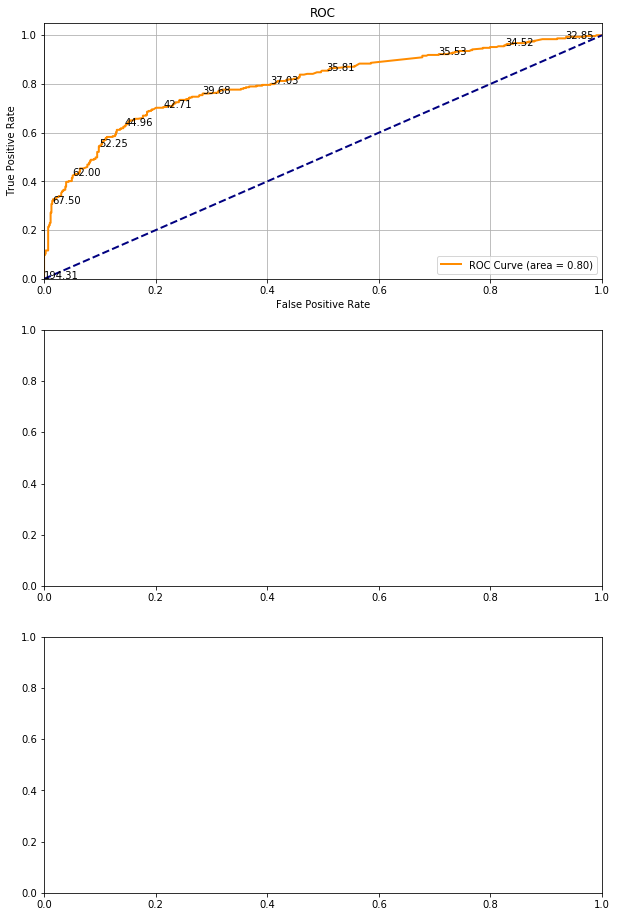

In [28]:
if W is not None:
    y_score = rfc.predict_proba(W)
    print(y_score.shape)
    
fpr,tpr,th = roc_curve(test_pred,y_score[:,1])
roc_auc = auc(fpr,tpr)

f,ax = plt.subplots(3,figsize=(10,16))


ax[0].plot(fpr,tpr,color='darkorange',lw=2,label='ROC Curve (area = %0.2f)' % roc_auc)
for i,(f,t,c) in enumerate(zip(fpr,tpr,th)):
    if i%n==0:
        ax[0].text(f,t,'{:.2f}'.format(100*c))
        

ax[0].plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
ax[0].set_xlim([0.0,1.0])
ax[0].set_ylim([0.0,1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC')
ax[0].legend(loc='lower right')
ax[0].grid()

# Checking the ROC_AUC Score

In [29]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(tester['RF_Model'],test_pred))

0.762768817204301
